# import

In [18]:
from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping

import numpy as np
import resnet
from keras.models import load_model

In [22]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
csv_logger = CSVLogger('resnet18_cifar10.csv')

batch_size = 32
nb_classes = 10
nb_epoch = 200
data_augmentation = True

# input image dimensions
img_rows, img_cols = 32, 32
# The CIFAR10 images are RGB.
img_channels = 3

# The data, shuffled and split between train and test sets:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Convert class vectors to binary class matrices.
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# subtract mean and normalize
# mean_image = np.mean(X_train, axis=0)
# X_train -= mean_image
# X_test -= mean_image
# X_train /= 128.
# X_test /= 128.

In [23]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=(X_test, Y_test),
              shuffle=True,
              callbacks=[lr_reducer, early_stopper, csv_logger])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_test, Y_test),
                        epochs=nb_epoch, verbose=1, max_q_size=100,
                        callbacks=[lr_reducer, early_stopper, csv_logger])

Using real-time data augmentation.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=1562, validation_data=(array([[[..., epochs=200, verbose=1, callbacks=[<keras.ca..., max_queue_size=100)`


Epoch 1/200
  35/1562 [..............................] - ETA: 6:10:55 - loss: 2.9112 - acc: 0.2643

KeyboardInterrupt: 

# トレーニング

In [1]:
import pytest

from keras import backend as K
from resnet import ResnetBuilder


DIM_ORDERING = {'th', 'tf'}


def _test_model_compile(model):
    for ordering in DIM_ORDERING:
        K.set_image_dim_ordering(ordering)
        model.compile(loss="categorical_crossentropy", optimizer="sgd")
        assert True, "Failed to compile with '{}' dim ordering".format(ordering)


def test_resnet18():
    model = ResnetBuilder.build_resnet_18((3, 224, 224), 100)
    _test_model_compile(model)


def test_resnet34():
    model = ResnetBuilder.build_resnet_34((3, 224, 224), 100)
    _test_model_compile(model)


def test_resnet50():
    model = ResnetBuilder.build_resnet_50((3, 224, 224), 100)
    _test_model_compile(model)


def test_resnet101():
    model = ResnetBuilder.build_resnet_101((3, 224, 224), 100)
    _test_model_compile(model)


def test_resnet152():
    model = ResnetBuilder.build_resnet_152((3, 224, 224), 100)
    _test_model_compile(model)


def test_custom1():
    """ https://github.com/raghakot/keras-resnet/issues/34
    """
    model = ResnetBuilder.build_resnet_152((3, 300, 300), 100)
    _test_model_compile(model)


def test_custom2():
    """ https://github.com/raghakot/keras-resnet/issues/34
    """
    model = ResnetBuilder.build_resnet_152((3, 512, 512), 2)
    _test_model_compile(model)


if __name__ == '__main__':
    pytest.main([__file__])

Using TensorFlow backend.


NameError: name '__file__' is not defined

In [4]:
model = load_model('model.hdf5')

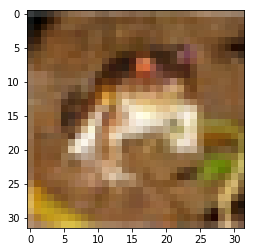

(<matplotlib.image.AxesImage at 0x2693c1de6a0>, None)

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

plt.imshow(X_train[0]),plt.show()

In [12]:
X_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [13]:
import numpy as np
def zscore(x, axis = None):
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    zscore = (x-xmean)/xstd
    return zscore

# subtract mean and normalize
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image
X_train /= 128.
X_test /= 128.

score = zscore(X_train[0])

In [14]:
score

array([[[-0.85518733, -0.79746585, -0.77822536],
        [-1.16303523, -1.10531375, -1.12455425],
        [-1.02835178, -1.06683276, -1.16303523],
        ...,
        [ 1.04962154,  0.54936871,  0.08759686],
        [ 0.93417858,  0.41468525, -0.02784611],
        [ 0.8572166 ,  0.39544476, -0.00860561]],

       [[-1.68252856, -1.60556659, -1.60556659],
        [-1.99037646, -1.99037646, -1.99037646],
        [-1.64404757, -1.83645251, -1.99037646],
        ...,
        [ 0.37620426, -0.29721302, -0.93214931],
        [ 0.29924229, -0.39341549, -1.02835178],
        [ 0.35696377, -0.31645351, -0.89366832]],

       [[-1.50936412, -1.52860461, -1.58632609],
        [-1.68252856, -1.855693  , -1.99037646],
        [-1.04759227, -1.47088313, -1.83645251],
        ...,
        [ 0.28000179, -0.37417499, -1.02835178],
        [ 0.31848278, -0.37417499, -1.02835178],
        [ 0.10683735, -0.58582042, -1.18227573]],

       ...,

       [[ 2.01164623,  1.28050747, -0.14328907],
        [ 1

In [16]:
X_train[0]

array([[[-0.56024015, -0.5785636 , -0.5433891 ],
        [-0.6807841 , -0.6987686 , -0.67854357],
        [-0.6332066 , -0.6894231 , -0.69985497],
        ...,
        [ 0.2104764 , -0.03364849, -0.1909436 ],
        [ 0.16880405, -0.08366001, -0.23437786],
        [ 0.13926566, -0.08963752, -0.22572231]],

       [[-0.8914008 , -0.900741  , -0.8700322 ],
        [-1.0105047 , -1.050462  , -1.0192626 ],
        [-0.87669456, -0.99356794, -1.024237  ],
        ...,
        [-0.05501986, -0.36827052, -0.59297013],
        [-0.08070612, -0.4028045 , -0.6288998 ],
        [-0.05591249, -0.37018502, -0.5738362 ]],

       [[-0.81816185, -0.8644389 , -0.8535266 ],
        [-0.88059855, -0.9882616 , -1.0079627 ],
        [-0.62869906, -0.8363708 , -0.94903016],
        ...,
        [-0.0875833 , -0.39029872, -0.6194842 ],
        [-0.06711674, -0.38704312, -0.6176975 ],
        [-0.15305734, -0.47310722, -0.68143404]],

       ...,

       [[ 0.6362991 ,  0.34411484, -0.14173514],
        [ 0

In [17]:
X_train[0].shape

(32, 32, 3)